In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST

In [5]:
print(torch.__version__)

1.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#import os
#os.chdir("/content/drive/My Drive") 
import ra
#import complexLayers


In [3]:
dataset = ra.read('atomsroa.ra')
train_data = torch.tensor(dataset)

In [4]:
train_data = train_data.imag
train_data =  torch.transpose(train_data, 0, 1).unsqueeze(1)

In [5]:
labelset = ra.read('paramsroa.ra')
train_label1 = torch.tensor(labelset)

In [6]:
dataset1 = ra.read('atoms.ra')
traindata1 = torch.tensor(dataset1)
traindata1 = traindata1.imag
traindata1 =  torch.transpose(traindata1, 0, 1).unsqueeze(1)
label1 = ra.read('params.ra')
label1 = torch.tensor(label1)

In [ ]:
print(traindata1)
print(train_data)

In [7]:
print(traindata1.shape)
train_data.shape

torch.Size([108056, 1, 1000])


torch.Size([108056, 1, 1000])

In [8]:
alldata = torch.cat((train_data,traindata1),0)

In [17]:
labels1 = torch.cat((train_label1[1,:],label1[1,:]),0)

In [19]:
print(labels1)
print(labels1.shape)
print(train_label1.shape)

tensor([  20.,   20.,   20.,  ..., 2000., 2000., 2000.], dtype=torch.float64)
torch.Size([216112])
torch.Size([3, 108056])


In [18]:
labels1 = torch.transpose(labels1)
print(labels1.shape)

TypeError: transpose() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, name dim0, name dim1)
 * (Tensor input, int dim0, int dim1)


In [20]:
import torch.utils.data as data
train_dataset = data.TensorDataset(alldata,labels1)

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=10).fit_transform(train_data)

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)

print(pca.explained_variance_ratio_.shape)
print(pca.components_.shape)
print(pca.singular_values_.shape)
print(pca.mean_.shape)

In [ ]:
train_data = torch.tensor(X_reduced)

In [21]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [140000, 60000 ,16112])

We found that the network model with smallest
average error for validation data consists of 3 convolutional layers (kernel size = 3, stride
size = 2), each followed by a rectified linear unit (ReLU) activation function. The number
of the feature maps per convolutional layer is increasing, from 32 in the first to 128 in
the last. After convolution an average pooling layer follows with the same size as the
stride size. The last layer is fully connected, with 2 outputs. 

In [22]:

# define baseline model
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=9, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=9, stride=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=9, stride=2)
        self.fc1 = nn.Linear(7040, 1)


    def forward(self, x):
        out = self.conv1(x)
        out = torch.relu(out)                                        
        out = self.conv2(out)
        out = torch.relu(out)
        out = self.conv3(out)
        out = torch.relu(out)
        out = F.avg_pool1d(out, kernel_size=9, stride=2)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [23]:
N = 200
val_loss = list()
#val_accu = list()
train_loss = list()
#train_accu = list()

In [24]:
#assert torch.cuda.is_available()
device1 = "cuda:0" if torch.cuda.is_available() else "cpu"
#cuda_device = torch.device("cuda")
seed = 7
torch.manual_seed(seed)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.float())
    yb = yb.float()
    outputs = torch.squeeze(outputs, 1)
    loss = loss_func(outputs, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

In [25]:

# build the model
model = BaselineModel().to(device1)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(N):
    model.train()
    running_loss = 0.0
    loss=0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        #inputs = inputs.unsqueeze(1).unsqueeze(-1)
        #inputs = inputs.unsqueeze(1)
        #inputs = torch.unsqueeze(inputs1, 2)

        inputs, labels = inputs.to(device1), labels.to(device1)
        
        
        loss, nums = loss_batch(model, loss_function, inputs.float(), labels.float(), optimiser)
        running_loss += loss
    train_loss.append(loss)

    model.eval()
    with torch.no_grad():
        losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in validloader]
            )
        val_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss.append(val_loss1)


        #print(epoch, val_loss)

        
        # keep track of the loss this epoch
        #running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 155847579.17
Epoch 1, loss 7334977.37
Epoch 2, loss 4154477.24
Epoch 3, loss 2800262.74
Epoch 4, loss 1925909.37
Epoch 5, loss 1483661.88
Epoch 6, loss 1130830.09
Epoch 7, loss 916951.91
Epoch 8, loss 725590.84
Epoch 9, loss 621739.37
Epoch 10, loss 463504.31
Epoch 11, loss 423284.43
Epoch 12, loss 370641.03
Epoch 13, loss 401162.36
Epoch 14, loss 282618.43
Epoch 15, loss 318656.92
Epoch 16, loss 235265.41
Epoch 17, loss 374870.60
Epoch 18, loss 300781.12
Epoch 19, loss 269576.04
Epoch 20, loss 241187.72
Epoch 21, loss 298485.32
Epoch 22, loss 182934.19
Epoch 23, loss 204814.12
Epoch 24, loss 165509.72
Epoch 25, loss 153086.54
Epoch 26, loss 157624.92
Epoch 27, loss 160551.84
Epoch 28, loss 147760.25
Epoch 29, loss 120286.16
Epoch 30, loss 137724.91
Epoch 31, loss 104675.90
Epoch 32, loss 96945.62
Epoch 33, loss 114837.88
Epoch 34, loss 162352.76
Epoch 35, loss 226167.23
Epoch 36, loss 172206.49
Epoch 37, loss 164485.96
Epoch 38, loss 150517.47
Epoch 39, loss 129114.73
Ep

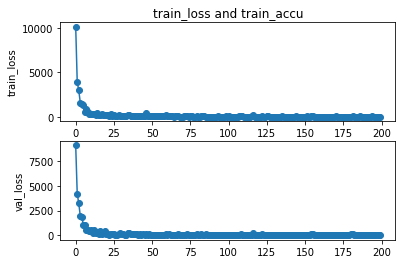

In [26]:
import matplotlib.pyplot as plt

x = range(0, N)
y1 = train_loss
#y2 = train_accu
y3 = val_loss
#y4 = val_accu
plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('train_loss and train_accu')
plt.ylabel('train_loss')
#plt.subplot(2, 1, 2)
#plt.plot(x, y2, '.-')
#plt.xlabel('epoches')
#plt.ylabel('train_accu')
plt.subplot(2, 1, 2)
plt.plot(x, y3, 'o-')
plt.ylabel('val_loss')
#plt.subplot(2, 2, 2)
#plt.plot(x, y4, '.-')
#plt.title('val_loss and val_accu')
#lt.ylabel('val_accu')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [24]:
print(y1)

[39162.5859375, 11763.650390625, 10699.044921875, 5103.5830078125, 4158.6142578125, 3056.337890625, 1703.7333984375, 1637.2615966796875, 1261.2879638671875, 1131.3231201171875, 1172.2281494140625, 1134.0067138671875, 678.216796875, 860.5421752929688, 1129.3348388671875, 630.5377197265625, 609.3250732421875, 568.7601318359375, 420.55645751953125, 319.82196044921875, 823.774658203125, 361.33343505859375, 336.67626953125, 302.5008544921875, 209.6558837890625, 315.412353515625, 342.5613708496094, 273.7820739746094, 166.2567138671875, 225.6500701904297, 247.6725311279297, 274.4014892578125, 310.10772705078125, 198.839111328125, 673.5882568359375, 266.2223205566406, 367.98138427734375, 179.63232421875, 228.9575653076172, 173.31272888183594, 252.89376831054688, 261.2034606933594, 175.7914276123047, 189.5096893310547, 148.1826171875, 178.23191833496094, 144.52645874023438, 137.4016876220703, 136.2789306640625, 249.77658081054688, 128.30670166015625, 1062.2835693359375, 158.63011169433594, 298.

In [36]:
print(train_loss) #1007

[10092.0859375, 3886.94140625, 2959.36962890625, 1582.9017333984375, 1401.4295654296875, 1313.5087890625, 512.7001953125, 861.7916870117188, 487.76629638671875, 286.4570617675781, 300.0074462890625, 296.589599609375, 306.38775634765625, 150.08767700195312, 368.0611267089844, 146.28085327148438, 138.94740295410156, 329.1799011230469, 187.454833984375, 200.4796600341797, 170.87191772460938, 146.4425048828125, 58.64010238647461, 254.98599243164062, 55.0732421875, 163.4866180419922, 92.71275329589844, 91.11582946777344, 149.1534881591797, 43.7850456237793, 38.724979400634766, 47.03095626831055, 52.68438720703125, 105.10093688964844, 190.47616577148438, 206.66415405273438, 124.12480926513672, 110.51681518554688, 60.5504264831543, 102.94188690185547, 76.93353271484375, 84.16749572753906, 99.96307373046875, 39.69801330566406, 51.03116989135742, 42.63930892944336, 368.14874267578125, 44.03279113769531, 117.3868408203125, 55.58649444580078, 31.26558494567871, 68.50475311279297, 48.5369529724121

In [25]:
print(y3)

[47070.75850833333, 14160.651023958333, 9504.357263541666, 5064.385265625, 3622.789198177083, 2555.7030783854166, 2865.3562497395833, 1652.871702669271, 1416.6655591796875, 2500.3363373697916, 1207.1820396484375, 824.034502734375, 846.8916470052084, 772.3470776692708, 959.6251580729166, 690.0691931640625, 706.3094733723958, 439.104155859375, 455.1469000325521, 599.4429361979167, 347.8273849609375, 325.42639397786456, 351.883117578125, 539.8078697916667, 335.9686100911458, 304.3679769856771, 294.8450935546875, 257.3579281901042, 332.04665408528643, 238.25290834147137, 273.2392374348958, 517.3467895996093, 242.07539473470052, 270.023981656901, 337.67350498046875, 307.2629343424479, 512.965322672526, 395.36957345377607, 242.02395505371095, 147.75177530924478, 285.53247884114586, 208.88724529622397, 163.93382548828126, 145.00982801513672, 144.96418704427083, 170.4312279296875, 179.63603095703124, 157.23783223470053, 145.18841010742187, 139.32339187825522, 150.5882546875, 1176.737731640625,

In [30]:
print(val_loss) #1007

[9062.06706796875, 4177.703197395834, 3232.6175463541667, 1965.9769560546874, 1884.4692690104166, 1062.2806412109376, 1036.3983814453125, 563.5325124023437, 539.3576021484375, 423.2604206705729, 560.7097671386719, 230.60498181966145, 494.41155587565106, 252.6835045247396, 375.5796235677083, 130.00352032063802, 407.97896533203124, 180.9929146158854, 197.2616155110677, 400.0778203938802, 174.7379357828776, 121.86832903645833, 81.65693728434245, 124.19652472330729, 101.11225670166016, 86.45203159179688, 77.18006107991536, 63.2129171875, 97.30806716308594, 269.61829301757814, 90.74596930745443, 91.22984610595704, 57.29694146321614, 43.53600529378255, 275.2471358154297, 202.37938856608073, 118.7464092203776, 118.04216057942709, 99.75488777669271, 125.50334877929687, 96.92447555338542, 78.78743844401042, 95.56105546875, 72.35999189453125, 100.75981362304688, 59.069937910970054, 99.46100601399739, 67.37759642130534, 115.49325799153645, 78.88635672607423, 46.54076417643229, 45.6286674194336, 4

In [31]:
model.eval()

BaselineModel(
  (conv1): Conv1d(1, 32, kernel_size=(9,), stride=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(9,), stride=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(9,), stride=(2,))
  (fc1): Linear(in_features=7040, out_features=1, bias=True)
)

In [32]:
model.eval()
test_loss = list()
for data in testloader:
    losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in testloader])
    test_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_loss.append(test_loss1)

In [33]:
import matplotlib.pyplot as plt

In [34]:
print(y3)

[1.9184374702722573, 1.9184374686149286, 1.918437463761323, 1.918437464116465, 1.9184374650635099, 1.918437467549503, 1.918437456776866, 1.9184374758361469, 1.9184374615120912, 1.9184374689700705, 1.9184374667208386, 1.9184374576055305, 1.9184374564217244, 1.918437462459136, 1.918437458670956, 1.9184374574871499, 1.9184374764280498, 1.918437451449738, 1.918437466010555, 1.918437470153877, 1.9184374681414063, 1.9184374709825411, 1.918437483057365, 1.918437471692825, 1.9184374638797037, 1.9184374572503886, 1.9184374515681186, 1.9184374719295862, 1.9184374626958973, 1.9184374487269835, 1.9184374621039944, 1.918437458434195, 1.918437454882776, 1.9184374681414063, 1.9184374612753299, 1.918437459026098, 1.9184374428079525, 1.9184374648267486, 1.9184374565401048, 1.9184374742971986, 1.9184374728766311, 1.9184374579606724, 1.9184374686149286, 1.9184374598547624, 1.9184374544092537, 1.9184374696803543, 1.9184374617488524, 1.9184374631694199, 1.9184374793875656, 1.9184374600915237, 1.91843747773

Text(0, 0.5, 'test_loss')

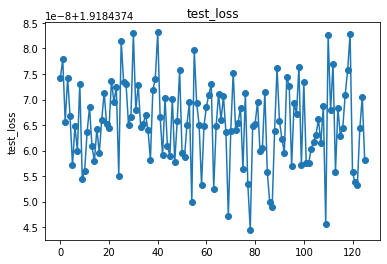

In [35]:
x = range(0, 126)
y3 = test_loss
plt.plot(x, y3, 'o-')
plt.title('test_loss')
plt.ylabel('test_loss')

In [31]:
for data in testloader:
    #print(data)
    inputs, lablels = data
    predictions = model(inputs.float())
    loss = loss_function(predictions,labels)
    losst1=loss_function(predictions[:,0],labels[:,0])
    losst1=loss_function(predictions[:,1],labels[:,1])
    loss = loss/128
    print("loss",loss)
    print("losst1",losst1)
    print("losst2",losst2)
    #print("predicted parameter:", predictions)
    #print("setting parameter:", labels)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
testdataset = ra.read('atomsroa.ra')
testdata = torch.tensor(testdataset)
testdata = testdata.imag
label1 = ra.read('paramsroa.ra')
label1 = torch.tensor(label1)

In [ ]:
for i in range(8056):
    inputs = testdata[:,i]
    lablels = label1[0,i]
    predictions = model(inputs.float())

    print("predicted parameter:", predictions)
    print("setting parameter:", lablels)

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the torch.save(state, filepath) function. This will save the weights of the model so they can be loaded into a new instance at a later point.

Run the following code to save the weights for use in the next part of the lab.

In [17]:
#save the trained model weights
torch.save(model.state_dict(), "./BaselineModel.weights")

If you are running on Colab, run the following to download the weights to the local machine:

In [ ]:
from google.colab import files
files.download('BaselineModel.weights')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BaselineModel(1000, 512, 256).to(device)
model.load_state_dict(torch.load('BaselineModel.weights'))